# Speech Emotion Recognition: A Comparative Study of Different Feature Spaces and Learning Models - 1D Feature Space

## Exploratory Data Analysis


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Important Libraries
import os
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display as disp
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras.utils import np_utils
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import opendatasets as od
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools 


In [ ]:
# Downloading Crema Dataset from Kaggle
od.download(
    "https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: ignored





## 1. Download the Dataset and Understand the Format (10 Points) 

In [ ]:
path = "Crema\\" 

In [ ]:
# Dictionary of emotions to convert from the string 
def to_emotion(emotion):
    emotions = {
        'SAD' : 'sad',
        'ANG' : 'angry',
        'DIS' : 'disgust',
        'NEU' : 'neural',
        'HAP' : 'happy',
        'FEA' : 'fear'
    }
    return emotions[emotion]

In [ ]:
file_names = os.listdir(path)

In [ ]:
# Define 2 empty lists to add the paths and the corresponding emotions
audio_path = []
audio_emotion = []

In [ ]:
for file in file_names:
    audio_path.append(os.path.join(path,file))
    emotion = file.split('_')[2]
    audio_emotion.append(to_emotion(emotion))

In [ ]:
# Create a Dataframe of audio_path and corresponding audio_emotion
dataset = pd.DataFrame({'path':audio_path,'emotion':audio_emotion})

In [ ]:
dataset

,path,emotion
0,Crema\1001_DFA_ANG_XX.wav,angry
1,Crema\1001_DFA_DIS_XX.wav,disgust
2,Crema\1001_DFA_FEA_XX.wav,fear
3,Crema\1001_DFA_HAP_XX.wav,happy
4,Crema\1001_DFA_NEU_XX.wav,neural
...,...,...
7437,Crema\1091_WSI_DIS_XX.wav,disgust
7438,Crema\1091_WSI_FEA_XX.wav,fear
7439,Crema\1091_WSI_HAP_XX.wav,happy
7440,Crema\1091_WSI_NEU_XX.wav,neural


In [ ]:
dataset = dataset.sort_values('path')

In [ ]:
# One hot encode the labels to be able to map them by the softmax layer
df_encoded_all = pd.get_dummies(dataset, columns=['emotion'])
labels = np.array(df_encoded_all.iloc[:, -6:])
labels

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
X = dataset.drop(labels="emotion", axis=1)
Y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.3, shuffle=True, stratify = Y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5209, 1), (2233, 1), (5209, 6), (2233, 6))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.05, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4948, 1), (2233, 1), (261, 1), (4948, 6), (2233, 6), (261, 6))

<AxesSubplot:xlabel='emotion', ylabel='Count'>

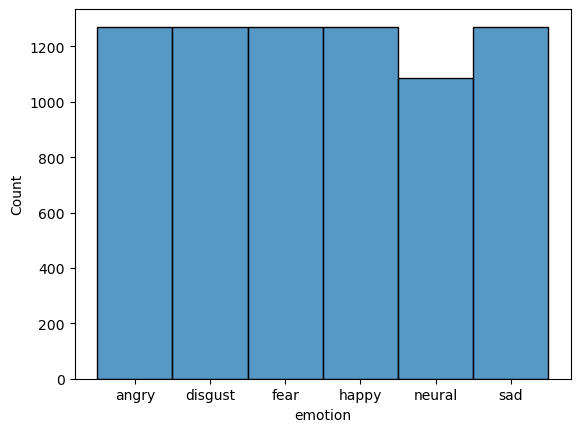

In [ ]:
# Exploring counts of each emotion and exploring whether the data is balanced or not
sns.histplot(dataset.emotion)

In [ ]:
# Creating new dataset with only an instance of each emotion
df = dataset.drop_duplicates(subset='emotion', keep='first', inplace=False, ignore_index=True)
df

,path,emotion
0,Crema\1001_DFA_ANG_XX.wav,angry
1,Crema\1001_DFA_DIS_XX.wav,disgust
2,Crema\1001_DFA_FEA_XX.wav,fear
3,Crema\1001_DFA_HAP_XX.wav,happy
4,Crema\1001_DFA_NEU_XX.wav,neural
5,Crema\1001_DFA_SAD_XX.wav,sad


In [ ]:
emotions = list(df['emotion'])
emotions

['angry', 'disgust', 'fear', 'happy', 'neural', 'sad']

#### Write your own function that loads an audio and listen to each of the classes you have and plot the waveform of the audio.

In [ ]:
# Explore each emotion for the same audio, listening to them and ploting their waveforms
def explore():
    for audio_path, emotion in zip(df['path'], df['emotion']):
        data, sampling_rate = librosa.load(audio_path);
        plt.figure()
        disp.waveshow(data, sr = sampling_rate)
        plt.title(f'Waveform for {emotion} audio')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.show()
        ipd.display(ipd.Audio(data, rate = sampling_rate))

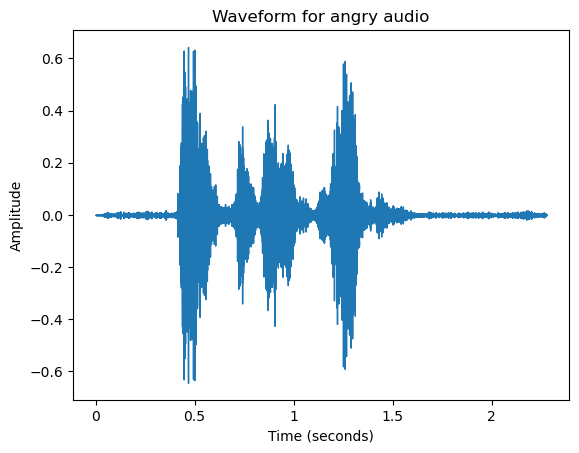

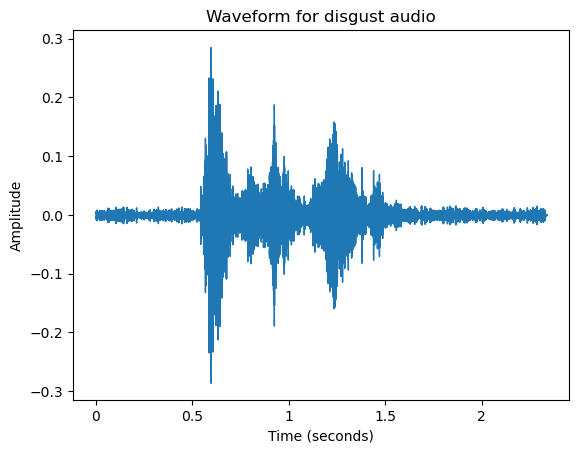

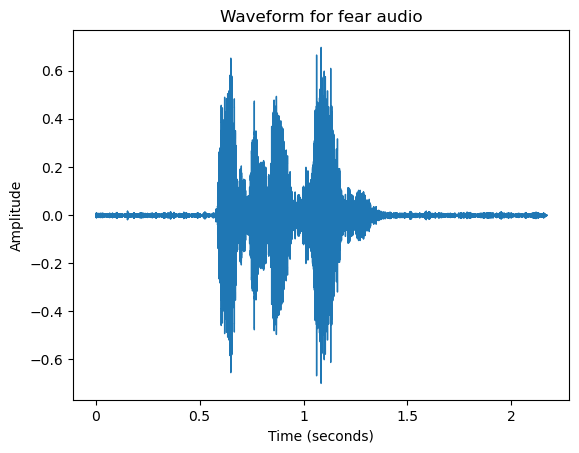

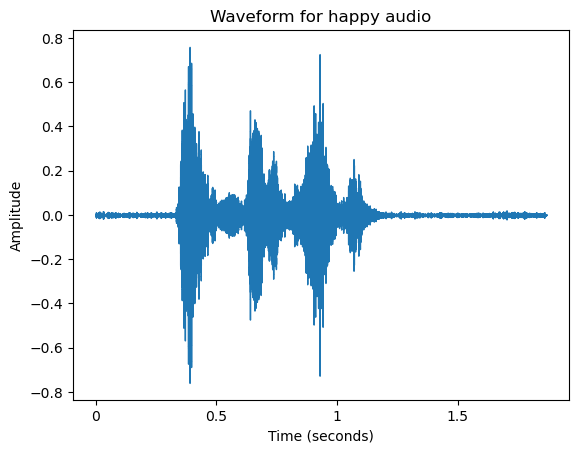

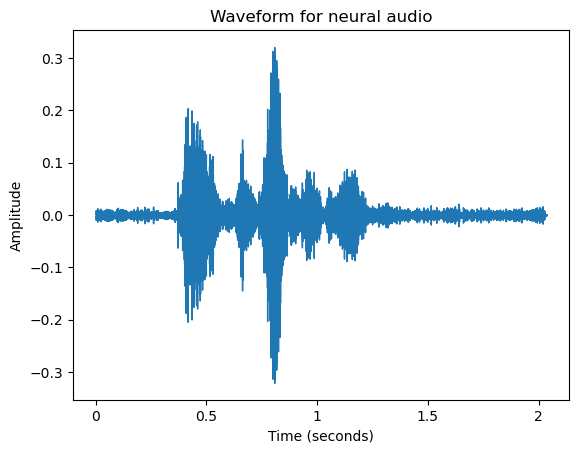

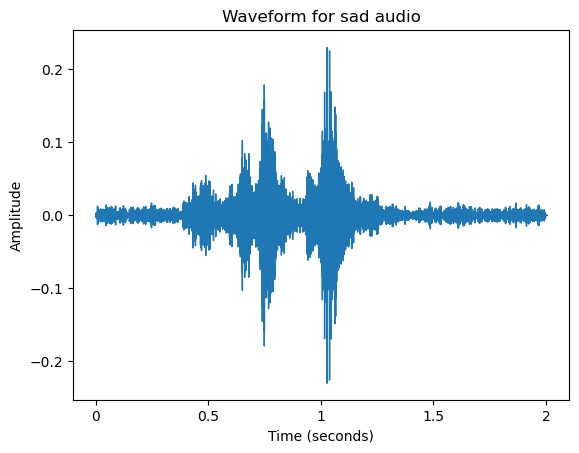

In [ ]:
explore()

### 2. Create the Feature Space [1D representation] (30 Points)

In [ ]:
# Creating feature representation for rms to explore dataset
y, sr = librosa.load('Crema\\1001_DFA_ANG_XX.wav')
rms = librosa.feature.rms(y = y)

In [ ]:
rms.shape

(1, 99)

In [ ]:
# Creating feature representation for Zero Crossing Rate
y, sr = librosa.load('Crema\\1001_DFA_ANG_XX.wav')
zcr = librosa.feature.zero_crossing_rate(y = y)

In [ ]:
zcr.shape

(1, 99)


## 2. Data Augmentation and Feature Extraction for 1D Feature Space

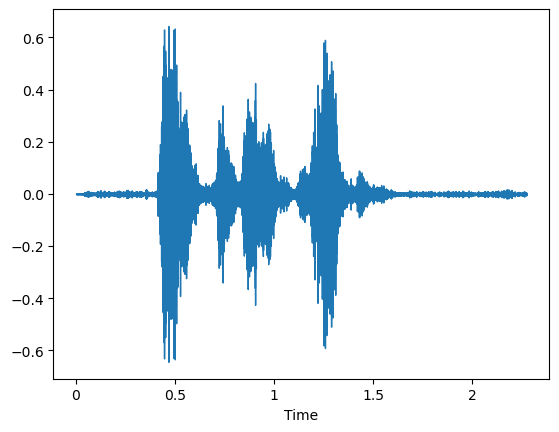

In [ ]:
# Audio file before any data augmentation to track differences 
disp.waveshow(y, sr = sr)
ipd.display(ipd.Audio(y, rate = sr))

##### Stretching:
Time stretching is a common audio augmentation technique used to modify the duration of an audio signal without altering its pitch. This technique is useful for creating variations of an audio signal that may have different lengths or durations, while maintaining the original characteristics of the sound.

In [ ]:
# Explore different augmentation techniques to get an intuition of the effect it may have on result
def stretch(data, rate = 0.8):
    return librosa.effects.time_stretch(data, rate = rate)

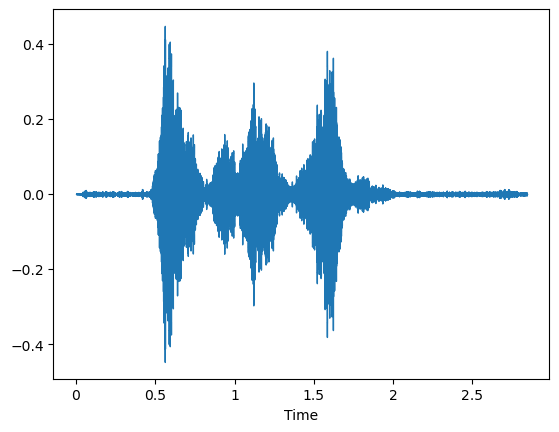

In [ ]:
disp.waveshow(stretch(y), sr = sr)
ipd.display(ipd.Audio(stretch(y), rate = sr))

###### Shifting:
The audio signal is shifted forward or backward in time by a small amount. This shift is applied uniformly across the entire waveform. 

In [ ]:
def shift(data, rate = 1000):
    shift_range = int(np.random.uniform(low = -5, high = 5)*rate)
    return np.roll(data, shift_range)

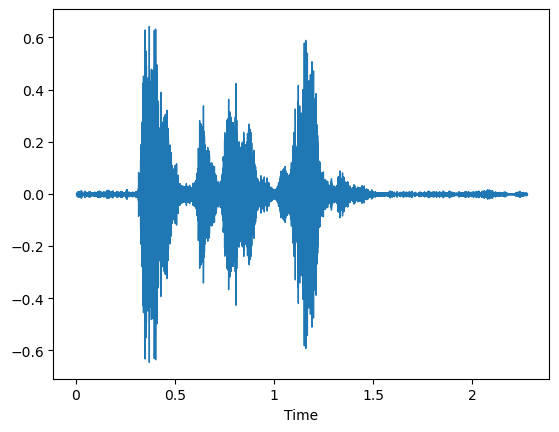

In [ ]:
disp.waveshow(shift(y), sr = sr)
ipd.display(ipd.Audio(shift(y), rate = sr))

###### Pitch:
The process of pitching data augmentation typically involves manipulating the fundamental frequency (F0) of the audio waveform. 

In [ ]:
def pitch(data, sampling_rate, pitch_factor = 0.5):
    pitch_factor = np.random.random()*pitch_factor
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

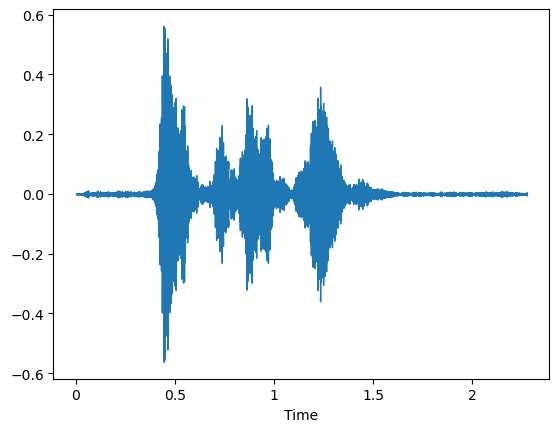

In [ ]:
disp.waveshow(pitch(y, sr), sr = sr)
ipd.display(ipd.Audio(pitch(y, sr), rate = sr))

###### Noise:

In [ ]:
def noise(data, threshold = 0.075):
    rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp * np.random.normal(size = data.shape[0])
    return data

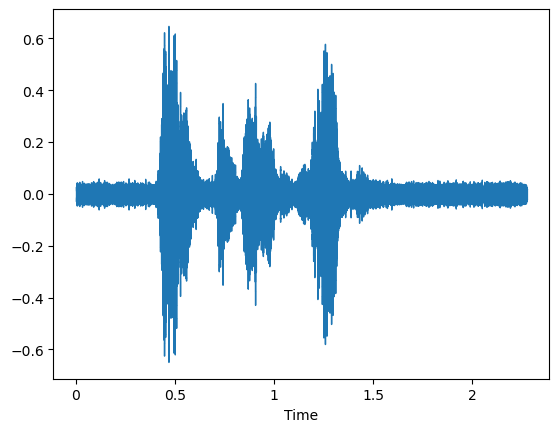

In [ ]:
disp.waveshow(noise(y), sr = sr)
ipd.display(ipd.Audio(noise(y), rate = sr))




### Creating the 1D feature space using the following features:
1. `Zero Crossing Rate` : The rate of sign-change of the signal during the duration of a particular frame.
2. `Energy`: The sum of squares of the signal values, normalized by the respective frame length.
3. `MFCCs Mel Frequency Cepstral Coefficients` form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
4. `Spectral Rolloff` : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
5. `Chroma` : Taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords. Used for audio matching and similarity.

In [ ]:
# Zero Crossing Rate
def zcr(data, frame_length = 2048, hop_length = 512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

In [ ]:
# Energy
def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length

In [ ]:
# MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.ravel(mfcc_feature.T)

In [ ]:
# Chroma
def chroma(data, sr):
      stft = np.abs(librosa.stft(data))
      chroma = librosa.feature.chroma_stft(S=stft, sr = sr).T
      return np.ravel(chroma)


In [ ]:
# Spectral Roll-Of
def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)

In [ ]:
# Checking the shapess of the extracted features

data, sr = librosa.load(dataset['path'][0])
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("MFCC: ", mfcc(data, sr).shape)
print("Spectral roll-of: ", spc_rollof(data, sr).shape)
print("Chroma: ", chroma(data, sr).shape)

ZCR:  (99,)
Energy:  (99,)
MFCC:  (1980,)
Spectral roll-of:  (99,)
Chroma:  (1188,)


In [ ]:
# For each sample horizontally stack each feature (ZCR, ENERGY, SPC_ROLLOF, CHROMA, MFCC)
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        energy(data, frame_length, hop_length),
                        spc_rollof(data, sr, frame_length, hop_length),
                        chroma(data, sr),
                        mfcc(data, sr, frame_length, hop_length)))
    return result

In [ ]:
data, sr = librosa.load(dataset['path'][0])
extract_features(data,sr).shape

(3465,)

In [ ]:
# Augmenting each sample with noise, pitch and white noise and vertically stacking them
def get_features(path, duration=2.5, offset=0.6):
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # Without Augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # Data with pitching
    pitched_data = pitch(data, sample_rate)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # Data with white_noise
    new_data = pitch(data, sample_rate)
    data_noise_pitch = noise(new_data)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically


    return result

In [ ]:
X_train.shape

(4948, 1)

In [ ]:
X_train.head()

,path
5319,Crema\1066_IEO_ANG_MD.wav
5853,Crema\1072_IWW_NEU_XX.wav
4062,Crema\1050_TAI_SAD_XX.wav
4184,Crema\1052_IEO_SAD_MD.wav
6780,Crema\1083_WSI_ANG_XX.wav


In [ ]:
y_train[0]

array([1, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
X_train_new, y_train_new = [], []
print("Feature processing...")
for path, emotion, ind in zip(X_train['path'], y_train, range(X_train['path'].shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for feature in features:
        X_train_new.append(feature)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        y_train_new.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

In [ ]:
X_test_new, y_test_new = [], []
print("Feature processing...")
for path, emotion, ind in zip(X_test['path'], y_test, range(X_test['path'].shape[0])):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)
    
     # Without Augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    X_test_new.append(result)
    # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    y_test_new.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...


C:\Users\Mohamed\anaconda3\lib\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
Done.


In [ ]:
X_test_new

[array([  0.02294922,   0.02783203,   0.03515625, ..., -10.72624493,
          3.25769067,  -4.17006588]),
 array([ 0.05957031,  0.08056641,  0.10498047, ...,  0.34456784,
        -0.00521135,  2.40618896]),
 array([ 0.07763672,  0.18603516,  0.27294922, ..., -3.06521273,
        -2.76995707, -7.73182058]),
 array([ 0.01367188,  0.02197266,  0.0390625 , ..., -3.17076969,
         0.226301  , -5.40874386]),
 array([ 0.171875  ,  0.25878906,  0.34814453, ..., -2.1946044 ,
         1.76265097,  1.04168534]),
 array([  0.01416016,   0.02099609,   0.02929688, ..., -10.70512009,
          1.83118844,   1.18639779]),
 array([ 0.01660156,  0.02246094,  0.03466797, ..., -8.30282307,
         2.71231961, -2.78151655]),
 array([0.04882812, 0.06738281, 0.08349609, ..., 4.18155289, 4.05803204,
        0.10535929]),
 array([ 0.07666016,  0.12109375,  0.16113281, ..., -4.8892827 ,
        -3.519454  , -3.39253378]),
 array([ 0.015625  ,  0.02392578,  0.02978516, ..., -2.93791151,
        -2.52458119,

In [ ]:
X_val_new, y_val_new = [], []
print("Feature processing...")
for path, emotion, ind in zip(X_val['path'], y_val, range(X_val['path'].shape[0])):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)
    
     # Without Augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    X_val_new.append(result)
    # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    y_val_new.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
Done.


In [ ]:
# Saving new dataset in a dataframe for further processing
X_train_df = pd.DataFrame(X_train_new)
X_train_df["labels"] = y_train_new
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,labels
0,0.176270,0.196289,0.210449,0.106934,0.059570,0.046875,0.043457,0.036621,0.039551,0.050781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 0, 0, 0, 0, 0]"
1,0.207520,0.249023,0.269043,0.173340,0.123047,0.130859,0.158203,0.174316,0.179199,0.166016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 0, 0, 0, 0, 0]"
2,0.172363,0.199219,0.214355,0.113281,0.067871,0.055176,0.053223,0.053223,0.051270,0.057617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 0, 0, 0, 0, 0]"
3,0.175293,0.202637,0.216797,0.118164,0.070801,0.061523,0.069824,0.069824,0.069824,0.072266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 0, 0, 0, 0, 0]"
4,0.017090,0.022949,0.038574,0.036133,0.035645,0.042480,0.041992,0.051270,0.052734,0.049316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 1, 0]"


In [ ]:
y_train = np.array([arr.tolist() for arr in y_train_new])

In [ ]:
# For each NAN in the dataframe replace it with a zero as if it is zero padding (Produced due to diffent lengths of audio)
X_train_df = X_train_df.fillna(0)

In [ ]:
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,labels
0,0.176270,0.196289,0.210449,0.106934,0.059570,0.046875,0.043457,0.036621,0.039551,0.050781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 0, 0, 0, 0, 0]"
1,0.207520,0.249023,0.269043,0.173340,0.123047,0.130859,0.158203,0.174316,0.179199,0.166016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 0, 0, 0, 0, 0]"
2,0.172363,0.199219,0.214355,0.113281,0.067871,0.055176,0.053223,0.053223,0.051270,0.057617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 0, 0, 0, 0, 0]"
3,0.175293,0.202637,0.216797,0.118164,0.070801,0.061523,0.069824,0.069824,0.069824,0.072266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 0, 0, 0, 0, 0]"
4,0.017090,0.022949,0.038574,0.036133,0.035645,0.042480,0.041992,0.051270,0.052734,0.049316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 1, 0]"


In [ ]:
X_train = X_train_df.drop(labels = 'labels', axis = 1)

In [ ]:
# Saving new dataset in a dataframe for further processing
X_test_df = pd.DataFrame(X_test_new)
X_test_df["labels"] = y_test_new
X_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,labels
0,0.022949,0.027832,0.035156,0.035645,0.027344,0.027344,0.029297,0.034180,0.028320,0.030273,...,-0.985961,-2.35085,-8.633386,4.801601,-9.977916,-3.238182,-10.726245,3.257691,-4.170066,"[0, 0, 1, 0, 0, 0]"
1,0.059570,0.080566,0.104980,0.099609,0.093262,0.087891,0.080078,0.069336,0.061035,0.071777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 1, 0, 0]"
2,0.077637,0.186035,0.272949,0.285156,0.224609,0.122559,0.048828,0.058105,0.079102,0.096191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 1, 0, 0]"
3,0.013672,0.021973,0.039062,0.052734,0.058594,0.065918,0.065918,0.062500,0.066406,0.067383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 1]"
4,0.171875,0.258789,0.348145,0.316406,0.239746,0.174805,0.099121,0.067871,0.061523,0.049805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0]"


In [ ]:
# For each NAN in the dataframe replace it with a zero as if it is zero padding (Produced due to diffent lengths of audio)
X_test_df = X_test_df.fillna(0)

In [ ]:
X_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,labels
0,0.022949,0.027832,0.035156,0.035645,0.027344,0.027344,0.029297,0.034180,0.028320,0.030273,...,-0.985961,-2.35085,-8.633386,4.801601,-9.977916,-3.238182,-10.726245,3.257691,-4.170066,"[0, 0, 1, 0, 0, 0]"
1,0.059570,0.080566,0.104980,0.099609,0.093262,0.087891,0.080078,0.069336,0.061035,0.071777,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 0, 0, 1, 0, 0]"
2,0.077637,0.186035,0.272949,0.285156,0.224609,0.122559,0.048828,0.058105,0.079102,0.096191,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 0, 0, 1, 0, 0]"
3,0.013672,0.021973,0.039062,0.052734,0.058594,0.065918,0.065918,0.062500,0.066406,0.067383,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 0, 0, 0, 0, 1]"
4,0.171875,0.258789,0.348145,0.316406,0.239746,0.174805,0.099121,0.067871,0.061523,0.049805,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 1, 0, 0, 0, 0]"


In [ ]:
y_test = np.array([arr.tolist() for arr in y_test_new])

In [ ]:
X_test = X_test_df.drop(labels = 'labels', axis = 1)

In [ ]:
# Saving new dataset in a dataframe for further processing
X_val_df = pd.DataFrame(X_val_new)
X_val_df["labels"] = y_val_new
X_val_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,labels
0,0.009766,0.013672,0.034180,0.039551,0.042969,0.046387,0.033203,0.030762,0.030273,0.027832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 1, 0, 0]"
1,0.013184,0.027832,0.038574,0.048340,0.066406,0.079590,0.097656,0.109375,0.102539,0.095215,...,-3.320473,0.857366,-5.208798,-3.745953,-8.722437,-2.499909,-3.773808,3.403438,-0.263142,"[0, 1, 0, 0, 0, 0]"
2,0.014160,0.022949,0.029297,0.028320,0.030273,0.026367,0.031250,0.034180,0.037109,0.043457,...,-10.015649,7.668749,-11.352917,-5.205622,-19.429089,0.467005,-7.412049,-5.036887,-10.667946,"[0, 0, 1, 0, 0, 0]"
3,0.035645,0.044922,0.052246,0.043457,0.029297,0.027344,0.038086,0.051758,0.070312,0.085938,...,2.099327,3.945517,1.493493,-0.737348,-1.848801,-3.437929,0.230594,-0.489208,0.953869,"[1, 0, 0, 0, 0, 0]"
4,0.011719,0.018066,0.024902,0.041504,0.054199,0.082031,0.094727,0.088379,0.081543,0.060059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 1, 0, 0, 0]"


In [ ]:
# For each NAN in the dataframe replace it with a zero as if it is zero padding (Produced due to diffent lengths of audio)
X_val_df = X_val_df.fillna(0)

In [ ]:
X_val_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3771,3772,3773,3774,3775,3776,3777,3778,3779,labels
0,0.009766,0.013672,0.034180,0.039551,0.042969,0.046387,0.033203,0.030762,0.030273,0.027832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 0, 0, 1, 0, 0]"
1,0.013184,0.027832,0.038574,0.048340,0.066406,0.079590,0.097656,0.109375,0.102539,0.095215,...,-3.320473,0.857366,-5.208798,-3.745953,-8.722437,-2.499909,-3.773808,3.403438,-0.263142,"[0, 1, 0, 0, 0, 0]"
2,0.014160,0.022949,0.029297,0.028320,0.030273,0.026367,0.031250,0.034180,0.037109,0.043457,...,-10.015649,7.668749,-11.352917,-5.205622,-19.429089,0.467005,-7.412049,-5.036887,-10.667946,"[0, 0, 1, 0, 0, 0]"
3,0.035645,0.044922,0.052246,0.043457,0.029297,0.027344,0.038086,0.051758,0.070312,0.085938,...,2.099327,3.945517,1.493493,-0.737348,-1.848801,-3.437929,0.230594,-0.489208,0.953869,"[1, 0, 0, 0, 0, 0]"
4,0.011719,0.018066,0.024902,0.041504,0.054199,0.082031,0.094727,0.088379,0.081543,0.060059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[0, 0, 1, 0, 0, 0]"


In [ ]:
y_val = np.array([arr.tolist() for arr in y_val_new])

In [ ]:
X_val = X_val_df.drop(labels = 'labels', axis = 1)

In [ ]:
from numpy import savetxt
savetxt('train_1D.csv', X_train, delimiter=',')
savetxt('test_1D.csv', X_test, delimiter=',')
savetxt('val_1D.csv', X_val, delimiter=',')
savetxt('label_train_1D.csv', y_train, delimiter=',')
savetxt('label_test_1D.csv', y_test, delimiter=',')
savetxt('label_val_1D.csv', y_val, delimiter=',')

`Splitting the Dataset`:
1. Split the data into 70% training and validation and 
30% testing. 
2. Use 5% of the training and validation data for 
validation

The next cell is not needed anymore as it was first used to save the dataframes after the split in google drive 

Note: it is important to save the data after the split to keep training the model on the same X_train and keep the test data unknown

In [ ]:
# from numpy import savetxt
# savetxt('train_1D.csv', X_train, delimiter=',')
# savetxt('test_1D.csv', X_test, delimiter=',')
# savetxt('val_1D.csv', X_val, delimiter=',')
# savetxt('label_train_1D.csv', y_train, delimiter=',')
# savetxt('label_test_1D.csv', y_test, delimiter=',')
# savetxt('label_val_1D.csv', y_val, delimiter=',')

In [ ]:
# from numpy import loadtxt
# trial = loadtxt('label_val_1D.csv', delimiter=',')

________________________________________________

## 3. Building the Model (40 Points)

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Getting the saved dataset after feature extraction from the drive
X_val_path = '/content/drive/MyDrive/speech recognition/NEW/val_1D.csv'
X_test_path = '/content/drive/MyDrive/speech recognition/NEW/test_1D.csv'
X_train_path = '/content/drive/MyDrive/speech recognition/NEW/train_1D.csv'
label_val_path = '/content/drive/MyDrive/speech recognition/NEW/label_val_1D.csv'
label_test_path = '/content/drive/MyDrive/speech recognition/NEW/label_test_1D.csv'
label_train_path = '/content/drive/MyDrive/speech recognition/NEW/label_train_1D.csv'

In [58]:
X_val = pd.read_csv(X_val_path , header = None)
X_test = pd.read_csv(X_test_path , header = None)
X_train = pd.read_csv(X_train_path , header = None)
y_train = pd.read_csv(label_train_path, header = None)
y_test = pd.read_csv(label_test_path, header = None)
y_val = pd.read_csv(label_val_path, header = None)

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((19792, 3780), (2233, 3780), (261, 3780), (19792, 6), (2233, 6), (261, 6))

In [60]:
X_train = np.expand_dims(X_train, axis=2)
X_train.shape

(19792, 3780, 1)

In [61]:
X_val = np.expand_dims(X_val, axis=2)
X_val.shape

(261, 3780, 1)

In [62]:
X_test = np.expand_dims(X_test, axis=2)
X_test.shape

(2233, 3780, 1)

 ### **Accuracy Measures**

In [63]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
def plot_acc(history):
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['acc']
  train_loss = history.history['loss']
  test_acc = history.history['val_acc']
  test_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(train_loss, label = 'Training Loss')
  ax[0].plot(test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(train_acc, label = 'Training Accuracy')
  ax[1].plot(test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

In [65]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### **Callbacks**

In [66]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [67]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [68]:
checkpoint_path  = "/content/drive/MyDrive/speech recognition/NEW/weights1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    monitor = 'val_acc',
    mode = 'max')

### **1D CNN Model**

In [69]:
model = models.Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation="softmax"))

l2_lambda = 0.01  # Regularization parameter
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)

In [70]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 3780, 256)         1536      
                                                                 
 batch_normalization_6 (Batc  (None, 3780, 256)        1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1890, 256)        0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1890, 256)         327936    
                                                                 
 batch_normalization_7 (Batc  (None, 1890, 256)        1024      
 hNormalization)                                                 
                                                      

In [72]:
EPOCHS = 50
batch_size = 32

## 4. Running the Model and Evaluating Performance

In [73]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction, cp_callback])

Epoch 1/50
619/619 [==============================] - ETA: 0s - loss: 1.6051 - acc: 0.3848 - f1_m: 0.2752
Epoch 1: val_acc improved from -inf to 0.30268, saving model to /content/drive/MyDrive/speech recognition/NEW/weights1/cp-0001.ckpt
619/619 [==============================] - 99s 102ms/step - loss: 1.6051 - acc: 0.3848 - f1_m: 0.2752 - val_loss: 1.7905 - val_acc: 0.3027 - val_f1_m: 0.2020 - lr: 0.0010
Epoch 2/50
619/619 [==============================] - ETA: 0s - loss: 1.2834 - acc: 0.4943 - f1_m: 0.4097
Epoch 2: val_acc improved from 0.30268 to 0.36782, saving model to /content/drive/MyDrive/speech recognition/NEW/weights1/cp-0002.ckpt
619/619 [==============================] - 63s 101ms/step - loss: 1.2834 - acc: 0.4943 - f1_m: 0.4097 - val_loss: 1.8335 - val_acc: 0.3678 - val_f1_m: 0.3181 - lr: 0.0010
Epoch 3/50
619/619 [==============================] - ETA: 0s - loss: 1.0802 - acc: 0.5859 - f1_m: 0.5370
Epoch 3: val_acc improved from 0.36782 to 0.37548, saving model to /conte

70/70 [==============================] - 2s 30ms/step - loss: 4.2940 - acc: 0.4308 - f1_m: 0.4292
Accuracy of our model on test data :  43.08105707168579 %


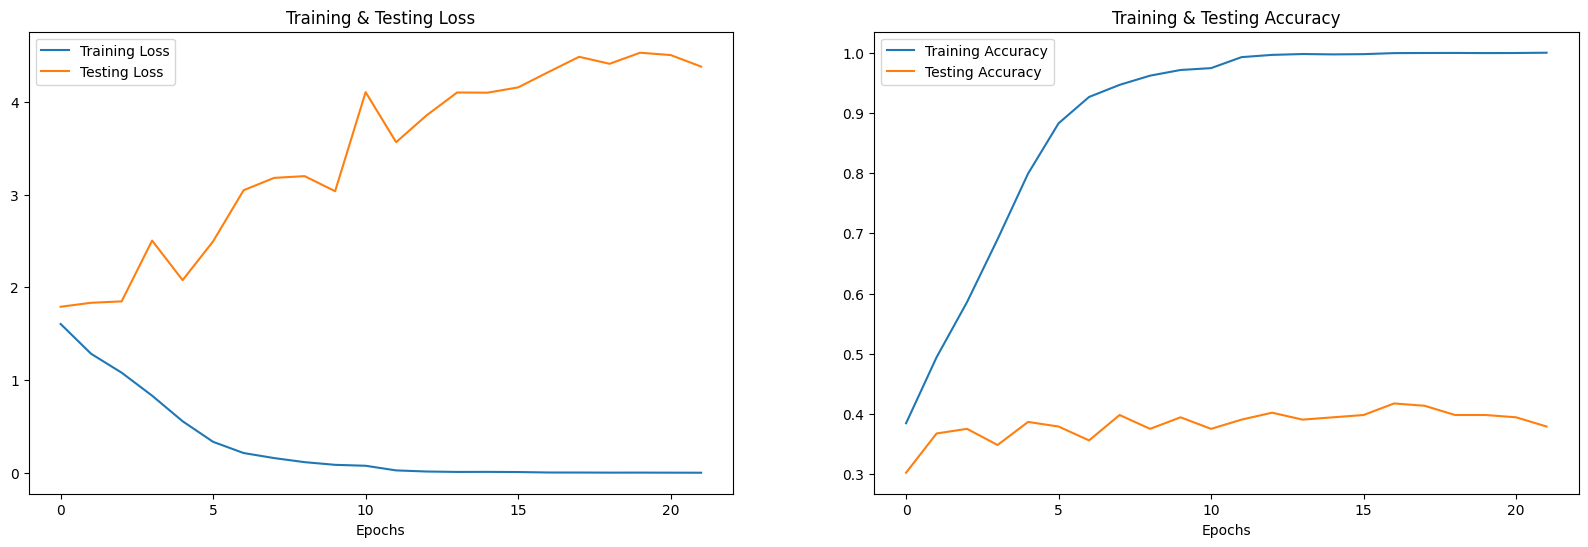

In [74]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")
plot_acc(history)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

70/70 [==============================] - 2s 29ms/step


array([2, 3, 3, ..., 2, 0, 2])

In [ ]:
y_check = np.argmax(np.array(y_test), axis=1)
y_check

array([2, 3, 3, ..., 3, 3, 4])

In [ ]:
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

Confusion matrix, without normalization
[[214  52  32  65  13   5]
 [ 44 137  49  53  48  51]
 [ 28  38 148  69  25  73]
 [ 76  32  74 150  32  17]
 [ 18  36  50  51 121  50]
 [  6  49  76  22  63 166]]


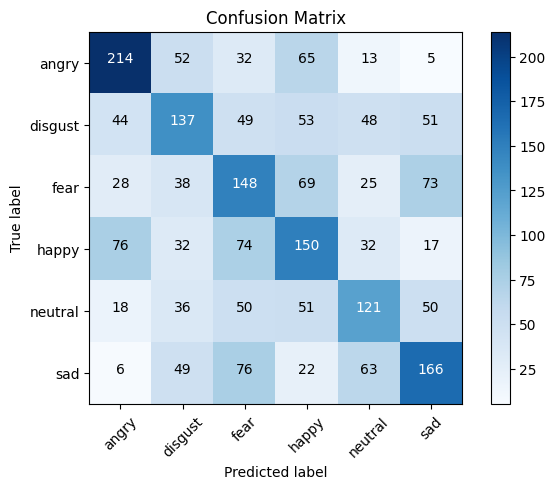

In [ ]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## 5. Running the model with saved weights. Transfer Learning approach

In [76]:
# If we want to re-run the model with the pre-trained weights, use this cell.
model.load_weights('/content/drive/MyDrive/speech recognition/NEW/weights1/cp-0017.ckpt')

In [77]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

70/70 [==============================] - 2s 30ms/step - loss: 4.2940 - acc: 0.4308 - f1_m: 0.4292
Accuracy of our model on test data :  43.08105707168579 %


In [78]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=10, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction, cp_callback])

Epoch 1/10
619/619 [==============================] - ETA: 0s - loss: 0.0039 - acc: 0.9991 - f1_m: 0.9992
Epoch 1: val_acc did not improve from 0.41762
619/619 [==============================] - 63s 101ms/step - loss: 0.0039 - acc: 0.9991 - f1_m: 0.9992 - val_loss: 4.2476 - val_acc: 0.3793 - val_f1_m: 0.3811 - lr: 2.5000e-04
Epoch 2/10
619/619 [==============================] - ETA: 0s - loss: 0.0028 - acc: 0.9993 - f1_m: 0.9993
Epoch 2: val_acc did not improve from 0.41762
619/619 [==============================] - 63s 101ms/step - loss: 0.0028 - acc: 0.9993 - f1_m: 0.9993 - val_loss: 4.4048 - val_acc: 0.3985 - val_f1_m: 0.3791 - lr: 2.5000e-04
Epoch 3/10
619/619 [==============================] - ETA: 0s - loss: 0.0028 - acc: 0.9995 - f1_m: 0.9995
Epoch 3: val_acc did not improve from 0.41762
619/619 [==============================] - 62s 101ms/step - loss: 0.0028 - acc: 0.9995 - f1_m: 0.9995 - val_loss: 4.2622 - val_acc: 0.3985 - val_f1_m: 0.3980 - lr: 2.5000e-04
Epoch 4/10
619/619 

70/70 [==============================] - 2s 30ms/step - loss: 4.4069 - acc: 0.4227 - f1_m: 0.4251
Accuracy of our model on test data :  42.27496683597565 %


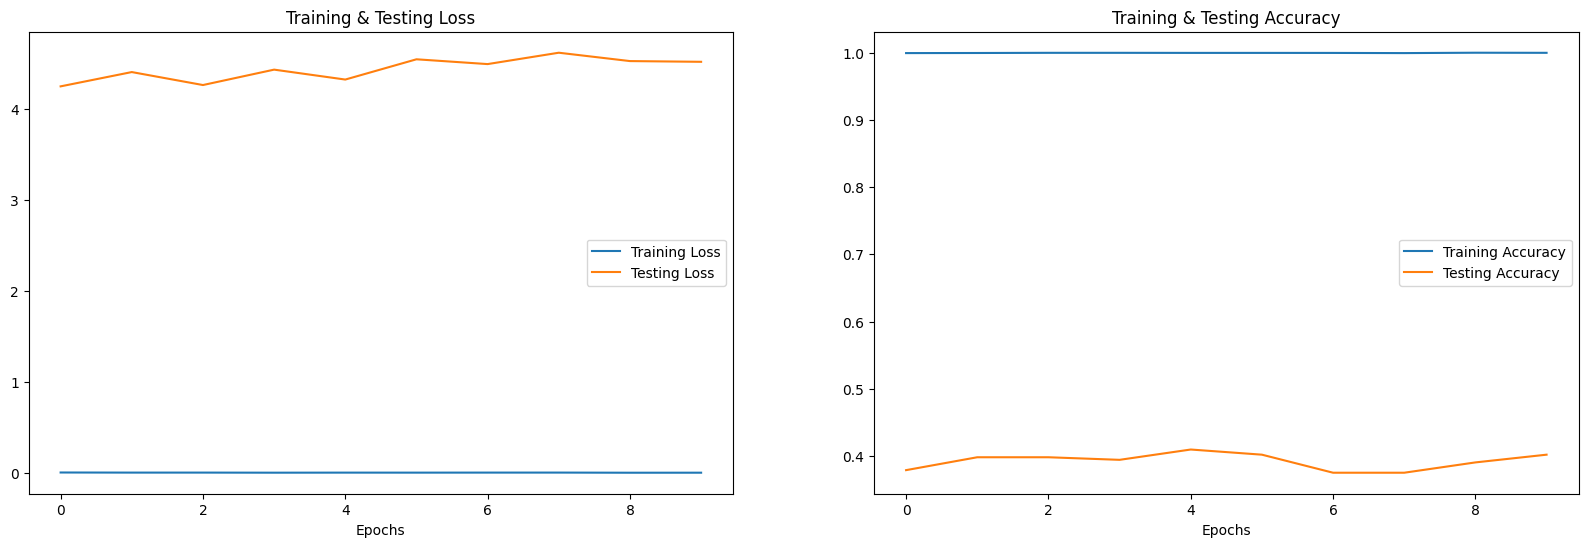

In [79]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")
plot_acc(history)